In [27]:
import time
import itertools
import re
import random
import os
import pickle


from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from lime.lime_text import LimeTextExplainer

from pennylane import numpy as np

import pennylane as qml
from concurrent.futures import ThreadPoolExecutor


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Nadam


from collections import defaultdict
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score




from collections import defaultdict

import nltk  #This is to do lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("omw-1.4")

import cloudpickle
from math import ceil

import tensorflow as tf

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\migue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\migue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\migue\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# PART 0: DATA LOADING AND PREPROCESSING

In [28]:


def clean_text(text):
    cleaned = re.sub(r'<.*?>', '', text).lower()
        # Tokenize into words
    tokens = word_tokenize(cleaned)
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Apply lemmatization to each token.
    # Here we use 'v' (verb) as the POS tag for simplicity.
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return ' '.join(lemmatized_tokens)

def load_imdb_subset(
    num_samples=5000, 
    min_df=1, 
    max_features=15, 
    stopwords_option=True,
    stop_words = 'english'
):
    
    data = load_files(
        r"C:/Users/migue/Downloads/aclImdb_v1/aclImdb/train",
        categories=['pos','neg'], 
        encoding="utf-8", 
        decode_error="replace"                  
    )

    X_text_all, y_all = data.data, data.target


    X_text_all = [clean_text(txt) for txt in X_text_all]
    

    # Shuffle & truncate to num_samples
    full_idx = np.arange(len(X_text_all))
    #np.random.shuffle(full_idx)
    subset_idx = full_idx[:num_samples]
    
    X_text = [X_text_all[i] for i in subset_idx]
    
    y = y_all[subset_idx]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=0
    )

    # Vectorizer: presence/absence
    if stopwords_option:
        vectorizer = CountVectorizer(
            binary=True, stop_words=stop_words, 
            min_df=min_df, max_features=max_features
        )
    else:
        vectorizer = CountVectorizer(
            binary=True, stop_words='english', 
            min_df=min_df, max_features=max_features
        )

    vectorizer.fit(X_train)
    return X_train, X_test, y_train, y_test, vectorizer



def train_NN_classifier(X_train, y_train, X_test, y_test, vectorizer):
    """
    Trains a neural network on the binary presence/absence of words.
    Returns the fitted model.
    """
    X_train_bow = vectorizer.transform(X_train)
    X_valid_bow = vectorizer.transform(X_test)
    input_dim = X_train_bow.shape[1]

    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),  # First hidden layer
        Dropout(0.3),  # Dropout with 30% probability
        Dense(64, activation='relu'),  # Second hidden layer
        Dropout(0.2),  # Dropout with 20% probability
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # Compile the model
    model.compile(optimizer=Nadam(learning_rate = 0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train_bow, y_train, epochs=30, batch_size=8, validation_data=(X_valid_bow, y_test), verbose=1, callbacks=[early_stopping])
    return model

def train_NN_classifier_filt(X_train_filt, y_train_filt, X_valid_filt, y_valid_filt, vectorizer_filt):
    """
    Trains a neural network on the binary presence/absence of words.
    Returns the fitted model.
    """
    X_train_bow = vectorizer_filt.transform(X_train_filt).toarray()
    X_valid_bow = vectorizer_filt.transform(X_valid_filt).toarray()
    input_dim = X_train_bow.shape[1]

    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),  # First hidden layer
        Dropout(0.3),  # Dropout with 30% probability
        Dense(64, activation='relu'),  # Second hidden layer
        Dropout(0.2),  # Dropout with 20% probability
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # Compile the model
    model.compile(optimizer=Nadam(learning_rate = 0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


    print(">>> X_train_bow shape:", X_train_bow.shape)
    print(">>> y_train shape:    ", y_train_filt.shape)
    print(">>> X_valid_bow shape:", X_valid_bow.shape)
    print(">>> y_valid shape:    ", y_valid_filt.shape)
    assert X_valid_bow.shape[0] == y_valid_filt.shape[0], "Validation features/labels mismatch!"

    model.fit(X_train_bow, y_train_filt, epochs=3, batch_size=8, validation_data=(X_valid_bow, y_valid_filt), verbose=1, callbacks=[early_stopping])
    return model

def get_cached_NN(X_train, y_train, vectorizer, num_samples, max_features, stop_words, X_valid, y_valid):

    filename = f"cached_classifier_ns{num_samples}_mf{max_features}_sw{stop_words}_NN_classifier_seed0.pkl"
    if os.path.exists(filename):
        print("Loading cached logistic from", filename)
        with open(filename, 'rb') as f:
            clNN = pickle.load(f)
    else:
        print("No cached classifier found. Training a new one...")
        clNN = train_NN_classifier(X_train, y_train, X_valid, y_valid, vectorizer)
        with open(filename, 'wb') as f:
            pickle.dump(clNN, f)
        print("Cached classifier saved as", filename)
    return clNN

# I don't need to create train_NN_classifier_filt no? both _filt and not _filt are the same, so it should be fine withouth it

def get_cached_NN_filt(threshold, X_train_filt, y_train_filt, vectorizer_filt, num_samples, max_features, X_valid_filt, y_valid_filt):
    filename = f"cached_classifier_threshold_{threshold}_ns{num_samples}_mf{max_features}_sw_LIME_filtered_NN_classifier_seed0.pkl"
    if os.path.exists(filename):
        print("Loading cached logistic from", filename)
        with open(filename, 'rb') as f:
            clNN_filt = pickle.load(f)
    else:
        print("No cached classifier found. Training a new one...")
        clNN_filt = train_NN_classifier_filt(X_train_filt, y_train_filt, X_valid_filt, y_valid_filt, vectorizer_filt)
        with open(filename, 'wb') as f:
            pickle.dump(clNN_filt, f)
        print("Cached classifier saved as", filename)
    return clNN_filt



def train_QCNN_classifier(X_train, y_train, X_test, y_test, vectorizer,
                           n_qubits=7, step_size=0.005, epochs=5, n_jobs=-1):
    class QCNNClassifier:
        def __init__(self, n_features, n_qubits=7, step_size=0.005, epochs=5, n_jobs=-1):
            self.n_feats    = n_features
            self.n_qubits   = n_qubits
            self.n_layers   = ceil(n_features / n_qubits)
            self.step_size  = step_size
            self.epochs     = epochs
            self.dev        = qml.device('default.qubit', wires=n_qubits)
            self.qnode      = qml.QNode(self._circuit, self.dev, interface='autograd')
            self.w_conv     = None
            self.w_ent      = None
            self.n_jobs     = n_jobs

        def _circuit(self, x, w_conv, w_ent):
            # 1) Re-upload feature blocks
            for i in range(self.n_layers):
                start = i * self.n_qubits
                end   = min((i+1) * self.n_qubits, self.n_feats)
                subx  = x[start:end]
                subx  = np.pad(subx, (0, self.n_qubits - len(subx)), constant_values=0)
                qml.templates.AngleEmbedding(subx, wires=range(self.n_qubits))
                qml.templates.StronglyEntanglingLayers(w_ent[i:i+1], wires=range(self.n_qubits))
            # 2) QCNN: conv + pooling
            wires = list(range(self.n_qubits))
            for _ in range(self.n_qubits - 1):
                for j in range(len(wires) - 1):
                    qml.CNOT(wires=[wires[j], wires[j+1]])
                    qml.RY(w_conv[j][0], wires=wires[j])
                    qml.RY(w_conv[j][1], wires=wires[j+1])
                qml.RY(0.0, wires=wires[-1]); qml.RZ(0.0, wires=wires[-1])
                wires = wires[:-1]
            return qml.expval(qml.PauliZ(0))

        def fit(self, X_train, y_train, X_val=None, y_val=None, batch_size=4):
            # Convert and remap labels to ±1
            X = np.array(X_train)
            y = np.where(np.array(y_train) > 0, 1.0, -1.0)

            if X_val is not None:
                Xv = np.array(X_val)
                yv = np.where(np.array(y_val) > 0, 1.0, -1.0)

            # Initialize weights
            self.w_conv = 0.05 * np.random.randn(self.n_qubits - 1, 2, requires_grad=True)
            self.w_ent  = 0.05 * np.random.randn(self.n_layers, self.n_qubits, 3, requires_grad=True)

            opt = qml.GradientDescentOptimizer(self.step_size)

            n_samples = len(X)
            for ep in range(1, self.epochs + 1):
                # Shuffle at start of each epoch
                perm = np.random.permutation(n_samples)
                X_shuf, y_shuf = X[perm], y[perm]

                # Mini-batch loop
                for start in range(0, n_samples, batch_size):
                    end = start + batch_size
                    xb = X_shuf[start:end]
                    yb = y_shuf[start:end]

                    # Define batch cost: average MSE over the batch
                    def batch_cost(wc, we):
                        preds = [ self.qnode(xi, wc, we) for xi in xb ]
                        return np.mean((np.array(preds) - yb) ** 2)

                    # Single optimizer step on this batch
                    self.w_conv, self.w_ent = opt.step(batch_cost, self.w_conv, self.w_ent)

                # --- end batch loop ---

                # Compute training metrics
                preds = Parallel(n_jobs=self.n_jobs)(
                    delayed(self.qnode)(xi, self.w_conv, self.w_ent) for xi in X
                )
                preds = np.array(preds)
                loss = np.mean((preds - y) ** 2)
                acc  = np.mean((preds > 0) == (y > 0))

                # Compute validation metrics if provided
                if X_val is not None:
                    vp = Parallel(n_jobs=self.n_jobs)(
                        delayed(self.qnode)(xi, self.w_conv, self.w_ent) for xi in Xv
                    )
                    vp = np.array(vp)
                    vloss = np.mean((vp - yv) ** 2)
                    vacc  = np.mean((vp > 0) == (yv > 0))
                    print(f"Epoch {ep:2d} | loss {loss:.4f}, acc {acc:.4f} | "
                        f"val loss {vloss:.4f}, val acc {vacc:.4f}")
                else:
                    print(f"Epoch {ep:2d} | loss {loss:.4f}, acc {acc:.4f}")


        def predict(self, X):
            X = np.array(X)
            out = Parallel(n_jobs=self.n_jobs)(delayed(self.qnode)(xi, self.w_conv, self.w_ent) for xi in X)
            out = np.array(out)
            return ((out + 1) / 2 > 0.5).astype(int)

        def save(self, fn):
            with open(fn, "wb") as f:
                cloudpickle.dump(self, f)

        @classmethod
        def load(cls, fn):
            with open(fn, "rb") as f:
                return cloudpickle.load(f)

        
        """
        Trains a QCNNClassifier on binary text data.
        Inputs:
        - X_train, X_test: raw text lists
        - y_train, y_test: binary labels (0/1)
        - vectorizer: fitted CountVectorizer
        - n_qubits, step_size, epochs, n_jobs: QCNN hyperparameters
        Returns:
        - model: trained QCNNClassifier
        """
        # --- Text cleaning helper (assumes same cleaning as before) ---
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer

    # Clean and vectorize

    Xtr_b = vectorizer.transform(X_train).toarray()
    Xte_b = vectorizer.transform(X_test).toarray()

    # Split out a validation set from training
    from sklearn.model_selection import train_test_split
    Xtr_b, Xv_b, ytr, yv = train_test_split(
        Xtr_b, y_train, test_size=0.2, random_state=0
    )

    model = QCNNClassifier(
        n_features=Xtr_b.shape[1],
        n_qubits=n_qubits,
        step_size=step_size,
        epochs=epochs,
        n_jobs=n_jobs
    )
    model.fit(Xtr_b, ytr, X_val=Xv_b, y_val=yv)

    # Evaluate on the test set
    y_pred = model.predict(Xte_b)
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y_test, y_pred)
    print(f"QCNN Test Accuracy: {acc:.4f}")

    return model

def get_cached_QCNN(X_train, y_train, vectorizer, X_test=None, y_test=None,
                    n_qubits=7, step_size=0.005, epochs=5, n_jobs=-1):
    """
    Retrieves cached QCNN model and vectorizer or trains/caches new ones.
    """
    # Define filenames
    model_file     = f"qcnn_imdb_unf.pkl"
    vectorizer_file= f"count_vectorizer_unf.pkl"

    # Load or train vectorizer
    if os.path.exists(vectorizer_file):
        print("Loading cached vectorizer from", vectorizer_file)
        with open(vectorizer_file, 'rb') as f:
            vectorizer = pickle.load(f)

    # Load or train model
    if os.path.exists(model_file):
        print("Loading cached QCNN model from", model_file)
        with open(model_file, 'rb') as f:
            model = cloudpickle.load(f)
    else:
        print("No cached QCNN found. Training and caching new model...")
        model = train_QCNN_classifier(
            X_train, y_train, X_test, y_test, vectorizer,
            n_qubits=n_qubits, step_size=step_size,
            epochs=epochs, n_jobs=n_jobs
        )
        with open(model_file, 'wb') as f:
            cloudpickle.dump(model, f)
        print("QCNN model saved to", model_file)

    return model, vectorizer
# model = train_QCNN_classifier(X_train, y_train, X_test, y_test, vectorizer)



def train_QCNN_classifier_filt(X_train_filt, y_train_filt, X_test_filt, y_test_filt, vectorizer_filt,
                           n_qubits=7, step_size=0.005, epochs=10, n_jobs=-1):
    class QCNNClassifier:
        def __init__(self, n_features, n_qubits=7, step_size=0.005, epochs=10, n_jobs=-1):
            self.n_feats    = n_features
            self.n_qubits   = n_qubits
            self.n_layers   = ceil(n_features / n_qubits)
            self.step_size  = step_size
            self.epochs     = epochs
            self.dev        = qml.device('default.qubit', wires=n_qubits)
            self.qnode      = qml.QNode(self._circuit, self.dev, interface='autograd')
            self.w_conv     = None
            self.w_ent      = None
            self.n_jobs     = n_jobs

        def _circuit(self, x, w_conv, w_ent):
            # 1) Re-upload feature blocks
            for i in range(self.n_layers):
                start = i * self.n_qubits
                end   = min((i+1) * self.n_qubits, self.n_feats)
                subx  = x[start:end]
                subx  = np.pad(subx, (0, self.n_qubits - len(subx)), constant_values=0)
                qml.templates.AngleEmbedding(subx, wires=range(self.n_qubits))
                qml.templates.StronglyEntanglingLayers(w_ent[i:i+1], wires=range(self.n_qubits))
            # 2) QCNN: conv + pooling
            wires = list(range(self.n_qubits))
            for _ in range(self.n_qubits - 1):
                for j in range(len(wires) - 1):
                    qml.CNOT(wires=[wires[j], wires[j+1]])
                    qml.RY(w_conv[j][0], wires=wires[j])
                    qml.RY(w_conv[j][1], wires=wires[j+1])
                qml.RY(0.0, wires=wires[-1]); qml.RZ(0.0, wires=wires[-1])
                wires = wires[:-1]
            return qml.expval(qml.PauliZ(0))

        def fit(self, X_train_filt, y_train_filt, X_val=None, y_val=None):
            X = np.array(X_train_filt); y = np.where(np.array(y_train_filt) > 0, 1.0, -1.0)
            if X_val is not None:
                Xv = np.array(X_val); yv = np.where(np.array(y_val) > 0, 1.0, -1.0)
            # initialize weights
            self.w_conv = 0.05 * np.random.randn(self.n_qubits - 1, 2, requires_grad=True)
            self.w_ent  = 0.05 * np.random.randn(self.n_layers, self.n_qubits, 3, requires_grad=True)

            opt = qml.GradientDescentOptimizer(self.step_size)
            for ep in range(1, self.epochs + 1):
                # sequential online update (batch training parallelization can be added similarly)
                for xi, yi in zip(X, y):
                    cost = lambda wc, we: (self.qnode(xi, wc, we) - yi) ** 2
                    self.w_conv, self.w_ent = opt.step(cost, self.w_conv, self.w_ent)
                # metrics
                preds = Parallel(n_jobs=self.n_jobs)(delayed(self.qnode)(xi, self.w_conv, self.w_ent) for xi in X)
                preds = np.array(preds)
                loss = np.mean((preds - y)**2); acc = np.mean((preds > 0) == (y > 0))
                if X_val is not None:
                    vp   = Parallel(n_jobs=self.n_jobs)(delayed(self.qnode)(xi, self.w_conv, self.w_ent) for xi in Xv)
                    vp   = np.array(vp); vloss = np.mean((vp - yv)**2);
                    vacc = np.mean((vp > 0) == (yv > 0))
                    print(f"filt: Epoch {ep:2d} | loss {loss:.4f}, acc {acc:.4f} | val loss {vloss:.4f}, val acc {vacc:.4f}")
                else:
                    print(f"filt: Epoch {ep:2d} | loss {loss:.4f}, acc {acc:.4f}")

        def predict(self, X):
            X = np.array(X)
            out = Parallel(n_jobs=self.n_jobs)(delayed(self.qnode)(xi, self.w_conv, self.w_ent) for xi in X)
            out = np.array(out)
            return ((out + 1) / 2 > 0.5).astype(int)

        def save(self, fn):
            with open(fn, "wb") as f:
                cloudpickle.dump(self, f)

        @classmethod
        def load(cls, fn):
            with open(fn, "rb") as f:
                return cloudpickle.load(f)

        
        """
        Trains a QCNNClassifier on binary text data.
        Inputs:
        - X_train, X_test: raw text lists
        - y_train, y_test: binary labels (0/1)
        - vectorizer: fitted CountVectorizer
        - n_qubits, step_size, epochs, n_jobs: QCNN hyperparameters
        Returns:
        - model: trained QCNNClassifier
        """
        # --- Text cleaning helper (assumes same cleaning as before) ---
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer

    # Clean and vectorize

    Xtr_b = vectorizer_filt.transform(X_train_filt).toarray()
    Xte_b = vectorizer_filt.transform(X_test_filt).toarray()

    # Split out a validation set from training
    from sklearn.model_selection import train_test_split
    Xtr_b, Xv_b, ytr, yv = train_test_split(
        Xtr_b, y_train_filt, test_size=0.2, random_state=0
    )

    model = QCNNClassifier(
        n_features=Xtr_b.shape[1],
        n_qubits=n_qubits,
        step_size=step_size,
        epochs=epochs,
        n_jobs=n_jobs
    )
    model.fit(Xtr_b, ytr, X_val=Xv_b, y_val=yv)

    # Evaluate on the test set
    y_pred = model.predict(Xte_b)
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y_test_filt, y_pred)
    print(f"QCNN Test Accuracy: {acc:.4f}")

    return model

def get_cached_QCNN_filt(threshold, X_train_filt, y_train_filt, vectorizer_filt, X_test_filt=None, y_test_filt=None,
                    n_qubits=7, step_size=0.005, epochs=5, n_jobs=-1):
    """
    Retrieves cached QCNN model and vectorizer or trains/caches new ones.
    """
    # Define filenames
    model_file     = f"qcnn_imdb_threshold_{threshold}_filt.pkl"
    vectorizer_file= f"count_vectorizer_threshold_{threshold}_filt.pkl"

    # Load or train vectorizer
    if os.path.exists(vectorizer_file):
        print("Loading cached vectorizer from", vectorizer_file)
        with open(vectorizer_file, 'rb') as f:
            vectorizer_filt = pickle.load(f)

    # Load or train model
    if os.path.exists(model_file):
        print("Loading cached QCNN model from", model_file)
        with open(model_file, 'rb') as f:
            model = cloudpickle.load(f)
    else:
        print("No cached QCNN found. Training and caching new model...")
        model = train_QCNN_classifier_filt(
            X_train_filt, y_train_filt, X_test_filt, y_test_filt, vectorizer_filt,
            n_qubits=n_qubits, step_size=step_size,
            epochs=epochs, n_jobs=n_jobs
        )
        with open(model_file, 'wb') as f:
            cloudpickle.dump(model, f)
        print("QCNN model saved to", model_file)

    return model, vectorizer_filt

def get_cached_QCNN(X_train, y_train, vectorizer, X_test=None, y_test=None,
                    n_qubits=7, step_size=0.005, epochs=10, n_jobs=-1):
    """
    Retrieves cached QCNN model and vectorizer or trains/caches new ones.
    """
    # Define filenames
    model_file     = f"qcnn_imdb_unf.pkl"
    vectorizer_file= f"count_vectorizer_unf.pkl"

    # Load or train vectorizer
    if os.path.exists(vectorizer_file):
        print("Loading cached vectorizer from", vectorizer_file)
        with open(vectorizer_file, 'rb') as f:
            vectorizer = pickle.load(f)

    # Load or train model
    if os.path.exists(model_file):
        print("Loading cached QCNN model from", model_file)
        with open(model_file, 'rb') as f:
            model = cloudpickle.load(f)
    else:
        print("No cached QCNN found. Training and caching new model...")
        model = train_QCNN_classifier(
            X_train, y_train, X_test, y_test, vectorizer,
            n_qubits=n_qubits, step_size=step_size,
            epochs=epochs, n_jobs=n_jobs
        )
        with open(model_file, 'wb') as f:
            cloudpickle.dump(model, f)
        print("QCNN model saved to", model_file)

    return model, vectorizer

# CLASSICAL LIME

In [29]:
def run_classical_lime(
    text_sample, clNN, vectorizer,  
    k_features=20, num_samples=50   
):
    
    """
    Runs classical LIME on a single text instance.
    Returns the top (word, weight) pairs.
    """
    class_names = ["negative", "positive"]
    explainer = LimeTextExplainer(class_names=class_names, feature_selection="auto")
    
    #@tf.function(reduce_retracing=True)
    def predict_proba(texts):
        bow = vectorizer.transform(texts) 
        #print('shaspe of box', bow.shape, ', text_sample:',text_sample, 'features: ', k_features, 'samples: ', num_samples)
        # print(bow)
        proba = clNN.predict(bow.toarray())
        if proba.ndim == 1:  # If 1D, reshape to (num_samples, 1)
            proba = proba.reshape(-1, 1)
        #print('proba', proba, 'dimension', proba.shape, 'return', np.hstack((1 - proba, proba)))
        return np.column_stack((1 - proba, proba))  # Return probabilities for both classes
        
        

    explanation = explainer.explain_instance(
        text_sample,
        predict_proba,
        num_features=k_features,
        num_samples=num_samples 
    )
    return explanation.as_list() 

# EXPERIMENTAL ROUTINE

In [30]:
def run_experiment(
    num_samples=500,
    min_df=1,
    max_features=15,
    stopwords_option=True,
    lime_num_samples=300,
    stop_words='english',
    max_features_filt=20
):

    X_train, X_test, y_train, y_test, _ = load_imdb_subset(
         num_samples=num_samples,
         min_df=min_df,
         max_features=max_features,
         stopwords_option=stopwords_option,
         stop_words=stop_words
     )
    

    vec_file = "count_vectorizer_unf.pkl"
    if os.path.exists(vec_file):
        print("Loading cached vectorizer from", vec_file)
        with open(vec_file, 'rb') as f:
            vectorizer = pickle.load(f)


    #clNN = get_cached_NN(X_train, y_train, vectorizer, num_samples, max_features, stop_words, X_test, y_test)
    clNN, _  = get_cached_QCNN(
    X_train, y_train, vectorizer,
    X_test=X_test, y_test=y_test,
    n_qubits=7, step_size=0.005,
    epochs=10, n_jobs=-1
)






    X_test_bow = vectorizer.transform(X_test).toarray()

    #X_test_bow = vectorizer.transform(X_test)
    y_test = y_test.reshape(-1, 1)
    test_acc = accuracy_score(y_test, clNN.predict(X_test_bow) > 0.5)

    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    X_all = X_train + X_test
    y_all = np.concatenate([y_train, y_test.ravel()])


    def process_sample_unfiltered(idx):
        text_sample = X_all[idx]
        # Run the lime computation for the sample
        explanation = run_classical_lime(
            text_sample, clNN, vectorizer,
            k_features=max_features, num_samples=lime_num_samples
        )
        # Compute absolute contributions
        contributions = [(word, abs(score)) for word, score in explanation]
        sample_dict = {}
        for word, weight in contributions:
            sample_dict.setdefault(word, []).append(weight)
        return sample_dict

    # There is a bug with the parallel
    # unf_results = Parallel(n_jobs=-1)(
    #     delayed(process_sample_unfiltered)(idx)
    #     for idx in range(len(X_all))
    # )

    # Run over all samples sequentially (to avoid QNode in subprocesses)
    unf_results = [ process_sample_unfiltered(idx) for idx in range(len(X_all)) ]


    # Merge the dictionaries from all samples.
    word_weights_unf = defaultdict(list)
    for d in unf_results:
        for word, weights in d.items():
            word_weights_unf[word].extend(weights)
    
    # Compute a global average per word.
    global_avg_weights_unf = {word: sum(wts) / len(wts) for word, wts in word_weights_unf.items()}
    threshold = 0.01
    rubish_words = {word: avg for word, avg in global_avg_weights_unf.items() if avg <= threshold}
    rubish_words_cleaned = {str(word): round(avg, 4) for word, avg in rubish_words.items()}
    filtered_words = {word: avg for word, avg in global_avg_weights_unf.items() if avg >= threshold}
    filtered_words_cleaned = {str(word): round(avg, 4) for word, avg in filtered_words.items()}

    # Use the number of deleted words to define the new feature count.
    features_filt = len(global_avg_weights_unf) - len(rubish_words_cleaned)

    # --- Create a filtered dataset and train the filtered NN model ---
    X_train_filt, X_test_filt, y_train_filt, y_test_filt, vectorizer_filt = load_imdb_subset(
        num_samples=num_samples,
        min_df=min_df,
        max_features=max_features,
        stopwords_option=stopwords_option,
        stop_words=stop_words + list(rubish_words.keys())
    )

    #clNN_filtered = get_cached_NN_filt(threshold, X_train_filt, y_train_filt, vectorizer_filt, num_samples, features_filt, X_test_filt, y_test_filt)

    clNN_filtered = get_cached_QCNN_filt(threshold, X_train_filt, y_train_filt, vectorizer_filt, num_samples, features_filt, X_test_filt, y_test_filt)

    # Prepare filtered data and corresponding true labels.
    X_all_filt = X_train_filt + X_test_filt
    y_all_filt = np.concatenate([y_train_filt, y_test_filt.ravel()])


    def process_sample_filtered(idx, y_true):
        text_sample_filt = X_all_filt[idx]
        explanation = run_classical_lime(
            text_sample_filt, clNN_filtered, vectorizer_filt,
            k_features=features_filt, num_samples=lime_num_samples
        )
        # Compute the prediction for this sample.
        bow_filt = vectorizer_filt.transform([text_sample_filt])
        y_pred = clNN_filtered.predict(bow_filt.toarray())[0].item()
        y_pred_label = 1 if y_pred >= 0.5 else 0
        instance_accuracy = int(y_pred_label == y_true)
        contributions = [(word, abs(score)) for word, score in explanation]
        sample_result = {'instance_accuracy': instance_accuracy, 'word_weights': {}}
        for word, weight in contributions:
            sample_result['word_weights'].setdefault(word, []).append(weight)
        return sample_result
    
    # There is a bug with the parallel
    # # Run the filtered loop in parallel over all filtered samples.
    # filt_results = Parallel(n_jobs=-1)(
    #     delayed(process_sample_filtered)(idx, y_all_filt[idx])
    #     for idx in range(len(X_all_filt))
    # )
    filt_results = [
        process_sample_filtered(idx, y_all_filt[idx])
        for idx in range(len(X_all_filt))
    ]


    # Combine the individual accuracies and word contributions.
    instance_local_accuracies = [res['instance_accuracy'] for res in filt_results]
    word_weights = defaultdict(list)
    for res in filt_results:
        for word, weights in res['word_weights'].items():
            word_weights[word].extend(weights)

    X_test_bow_filt = vectorizer_filt.transform(X_test_filt)
    list_sanity_check = ["y_test_filt_shape", y_test_filt.shape, "X_test_filt_shape", X_test_bow_filt.shape]
    test_acc_filt = accuracy_score(
        y_test_filt, 
        clNN_filtered.predict(X_test_bow_filt.toarray(), verbose=None) > 0.5
    )

    results = {
        "global_acc": np.mean(test_acc),  # Global accuracy before filtering
        "num_unf_words": len(word_weights_unf),
        "num_filt_words": len(filtered_words_cleaned),
        # "local_accuracy": np.mean(instance_local_accuracies),  # Lime local accuracies (if needed)
        "global_acc_filtered": np.mean(test_acc_filt),  # Global accuracy after filtering
        "list_deleted_words": rubish_words_cleaned,  # Words to delete
        "list_filt_words": filtered_words_cleaned,   # Words to keep
        "list_sanity_check":
            list_sanity_check,  # Sanity check for the filtered dataset
    }
    return results


In [31]:
import pandas as pd
import sys, os

sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.getcwd()))

if __name__ == "__main__":


    # Parameter grid to systematically vary certain settings # I still have to run ,2000, 3000 5000, 6000,7000,8000,9000,10000
    param_grid = {
        "num_samples": [5000],
        "max_features": [100],
        "stopwords_option": [True],
        "lime_num_samples": [1000],
        "stop_words": [['english']],
           
    }

    combos = list(itertools.product(*param_grid.values()))
    all_results = []

    for combo in combos:
        (num_samples_, max_features_, stopwords_, lime_samps_, stop_words_) = combo
        
        print("\n==================================")
        print(f"Running experiment with: "
              f"num_samples={num_samples_}, "
              f"max_features={max_features_}, "
              f"stopwords={stopwords_}, "
              f"lime_num_samples={lime_samps_}, "
              f"stop_words={stop_words_},")
        
        res = run_experiment(
            num_samples=num_samples_,
            max_features=max_features_,
            stopwords_option=stopwords_,
            lime_num_samples=lime_samps_,
            stop_words=stop_words_,
        )
        res_row = {
            "num_samples": num_samples_,
            "max_features": max_features_,
            "stopwords": stopwords_,
            "lime_num_samples": lime_samps_,
            #"local_accuracy": res["local_accuracy"],
            "global_acc": res["global_acc"],
            "global_acc_filtered": res["global_acc_filtered"],
            "num_unf_words": res["num_unf_words"],
            "num_filt_words": res["num_filt_words"], 
            "list_sanity_check": res["list_sanity_check"],  
            
            "list_deleted_words": res["list_deleted_words"], 
            "list_filt_words": res["list_filt_words"],  
            "list_sanity_check": res["list_sanity_check"],  
        }

        #print("Results =>", res_row)
        all_results.append(res_row)

    # Save results to CSV
    df = pd.DataFrame(all_results)

    df.to_csv("results_expanded_flips.csv", index=False)

    print("\nAll done! Saved results to 'results_expanded_flips.csv'.")


Running experiment with: num_samples=5000, max_features=100, stopwords=True, lime_num_samples=1000, stop_words=['english'],
Loading cached vectorizer from count_vectorizer_unf.pkl
Loading cached vectorizer from count_vectorizer_unf.pkl
Loading cached QCNN model from qcnn_imdb_unf.pkl
Shape of y_train: (4000,)
Shape of y_test: (1000, 1)


KeyboardInterrupt: 

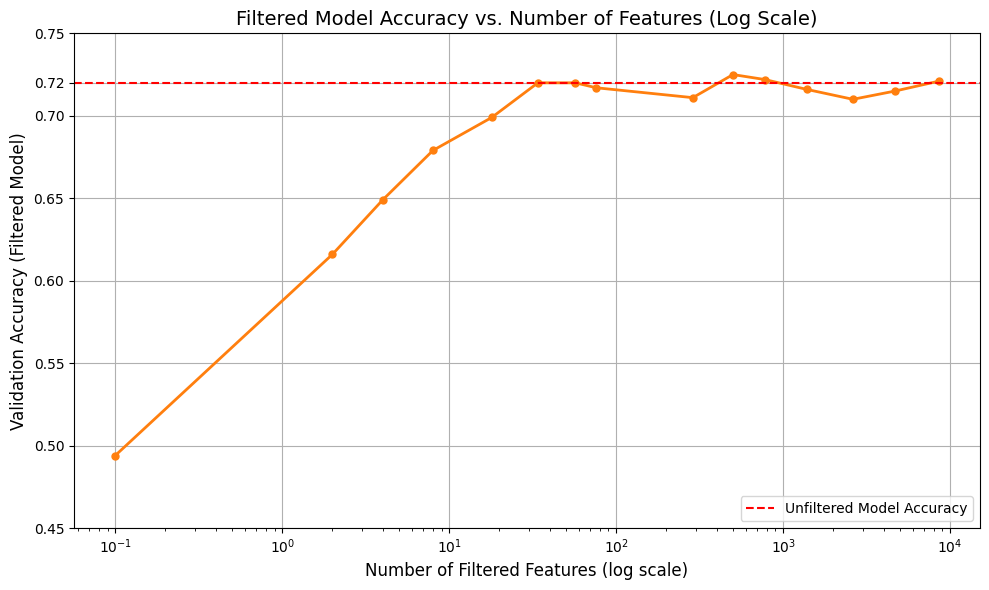

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your data
features = np.array([0, 2, 4, 8, 18, 34, 57, 76, 288, 501, 776, 1387, 2619, 4679, 8564])
accuracy = np.array([0.494, 0.616, 0.649, 0.679, 0.699, 0.720, 0.720,
                     0.717, 0.711, 0.725, 0.722, 0.716, 0.71, 0.715, 0.721])

# Avoid log(0) by replacing 0 with a small positive number
features_log = np.where(features == 0, 0.1, features)

# 1) Plot accuracy vs number of features (logarithmic x-axis)
plt.figure(figsize=(10, 6))
plt.plot(
    features_log,
    accuracy,
    marker='o',
    markersize=5,
    linewidth=2,
    color='tab:orange'
)

# 2) Add a horizontal line at 0.72 for the unfiltered model accuracy
plt.axhline(
    y=0.72,
    color='red',
    linestyle='--',
    label='Unfiltered Model Accuracy'
)

plt.xscale('log')  # Set x-axis to logarithmic scale

yticks = list(plt.yticks()[0])       # get current y‑ticks
yticks.append(0.72)                  # add 0.72
plt.yticks(sorted(set(yticks)))      # remove duplicates and sort

plt.xlabel('Number of Filtered Features (log scale)', fontsize=12)
plt.ylabel('Validation Accuracy (Filtered Model)', fontsize=12)
plt.title('Filtered Model Accuracy vs. Number of Features (Log Scale)', fontsize=14)
plt.grid(True)

# 3) Draw legend for the horizontal line with small font
plt.legend(
    loc='lower right',
    fontsize=10
)

plt.tight_layout()
plt.show()


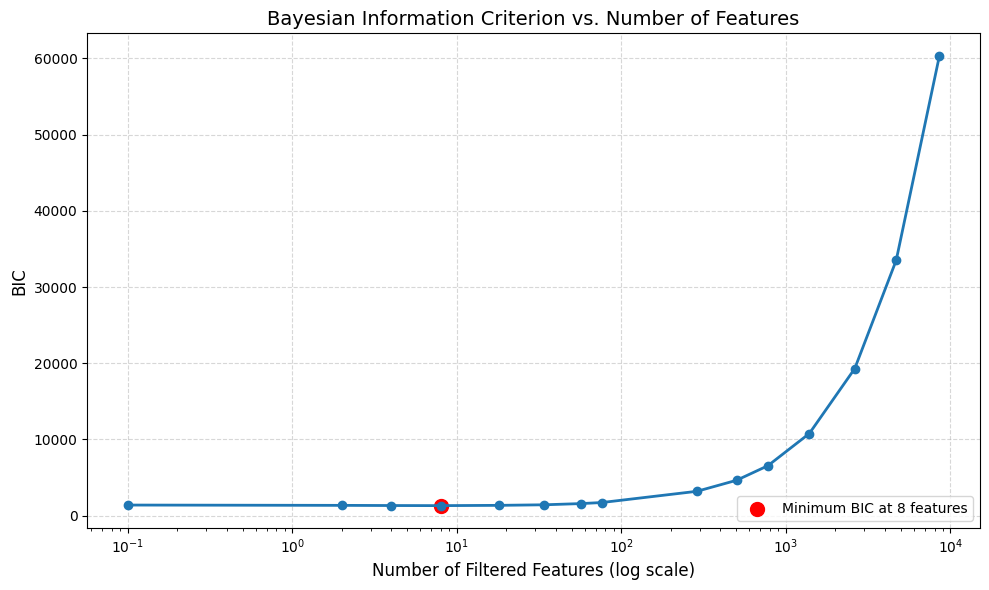

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Your data
features = np.array([0, 2, 4, 8, 18, 34, 57, 76, 288, 501, 776, 1387, 2619, 4679, 8564])
accuracy = np.array([0.494, 0.616, 0.649, 0.679, 0.699, 0.720, 0.720,
                     0.717, 0.711, 0.725, 0.722, 0.716, 0.71, 0.715, 0.721])

# Avoid log(0) for the x-axis plot
features_log = np.where(features == 0, 0.1, features)

# Validation‐set size
n_obs = 1000

# Clip to avoid log(0) in likelihood
a = np.clip(accuracy, 1e-6, 1 - 1e-6)

# Bernoulli log‐likelihood
log_likelihood = n_obs * (a * np.log(a) + (1 - a) * np.log(1 - a))

# Number of parameters
k = features + 1        # K may be dimension (4000)* 128 (layers)+ 128 (bias) etc., model.summary() should answer this

# BIC
bic = -2 * log_likelihood + k * np.log(n_obs)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(features_log, bic, marker='o', linewidth=2, color='tab:blue')

# Mark the minimum
min_idx = np.argmin(bic)
ax.scatter(features_log[min_idx], bic[min_idx],
           color='red', s=100,
           label=f'Minimum BIC at {features[min_idx]} features')

# Log-scale x-axis, linear y-axis
ax.set_xscale('log')

# Scientific notation on y-axis
#ax.ticklabel_format(axis='y', style='scientific')

# Labels & grid
ax.set_xlabel('Number of Filtered Features (log scale)', fontsize=12)
ax.set_ylabel('BIC', fontsize=12)
ax.set_title('Bayesian Information Criterion vs. Number of Features', fontsize=14)
ax.grid(True, ls='--', alpha=0.5)
ax.legend(fontsize=10, loc='lower right')

plt.tight_layout()
plt.show()


## QCNN with parallel 

In [ ]:
# import pickle
# import re
# from math import ceil
# from collections import defaultdict

# import pennylane as qml
# from pennylane import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.datasets import load_files
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# from joblib import Parallel, delayed
# import cloudpickle


# # --- Text cleaning ---
# def clean_text(text):
#     text = re.sub(r'<.*?>', '', text).lower()
#     tokens = word_tokenize(text)
#     lemmatizer = WordNetLemmatizer()
#     return ' '.join(lemmatizer.lemmatize(tok, pos='v') for tok in tokens)

# # --- Data loader with parallel cleaning ---
# def load_imdb_subset(
#     num_samples=5000,
#     min_df=1,
#     max_features=50,
#     stopwords_option=True,
#     stop_words='english',
#     n_jobs=-1
# ):
#     data = load_files(
#         r"C:/Users/migue/Downloads/aclImdb_v1/aclImdb/train",
#         categories=['pos', 'neg'], encoding="utf-8", decode_error="replace"
#     )
#     X_all, y_all = data.data, data.target
#     # Parallel cleaning
#     X_clean = Parallel(n_jobs=n_jobs)(delayed(clean_text)(doc) for doc in X_all)
#     idx = np.arange(len(X_clean))[:num_samples]
#     X_subset = [X_clean[i] for i in idx]
#     y_subset = y_all[idx]
#     X_train, X_test, y_train, y_test = train_test_split(
#         X_subset, y_subset, test_size=0.2, random_state=0
#     )
#     vec = CountVectorizer(
#         binary=True,
#         stop_words=(stop_words if stopwords_option else None),
#         min_df=min_df,
#         max_features=max_features
#     )
#     vec.fit(X_train)
#     return X_train, X_test, y_train, y_test, vec

# # --- QCNN Classifier with parallel predict ---
# class QCNNClassifier:
#     def __init__(self, n_features, n_qubits=7, step_size=0.005, epochs=10, n_jobs=-1):
#         self.n_feats    = n_features
#         self.n_qubits   = n_qubits
#         self.n_layers   = ceil(n_features / n_qubits)
#         self.step_size  = step_size
#         self.epochs     = epochs
#         self.dev        = qml.device('default.qubit', wires=n_qubits)
#         self.qnode      = qml.QNode(self._circuit, self.dev, interface='autograd')
#         self.w_conv     = None
#         self.w_ent      = None
#         self.n_jobs     = n_jobs

#     def _circuit(self, x, w_conv, w_ent):
#         # 1) Re-upload feature blocks
#         for i in range(self.n_layers):
#             start = i * self.n_qubits
#             end   = min((i+1) * self.n_qubits, self.n_feats)
#             subx  = x[start:end]
#             subx  = np.pad(subx, (0, self.n_qubits - len(subx)), constant_values=0)
#             qml.templates.AngleEmbedding(subx, wires=range(self.n_qubits))
#             qml.templates.StronglyEntanglingLayers(w_ent[i:i+1], wires=range(self.n_qubits))
#         # 2) QCNN: conv + pooling
#         wires = list(range(self.n_qubits))
#         for _ in range(self.n_qubits - 1):
#             for j in range(len(wires) - 1):
#                 qml.CNOT(wires=[wires[j], wires[j+1]])
#                 qml.RY(w_conv[j][0], wires=wires[j])
#                 qml.RY(w_conv[j][1], wires=wires[j+1])
#             qml.RY(0.0, wires=wires[-1]); qml.RZ(0.0, wires=wires[-1])
#             wires = wires[:-1]
#         return qml.expval(qml.PauliZ(0))

#     def fit(self, X_train, y_train, X_val=None, y_val=None, batch_size=8):
#         # Convert and remap labels to ±1
#         X = np.array(X_train)
#         y = np.where(np.array(y_train) > 0, 1.0, -1.0)

#         if X_val is not None:
#             Xv = np.array(X_val)
#             yv = np.where(np.array(y_val) > 0, 1.0, -1.0)

#         # Initialize weights
#         self.w_conv = 0.05 * np.random.randn(self.n_qubits - 1, 2, requires_grad=True)
#         self.w_ent  = 0.05 * np.random.randn(self.n_layers, self.n_qubits, 3, requires_grad=True)

#         opt = qml.GradientDescentOptimizer(self.step_size)

#         n_samples = len(X)
#         for ep in range(1, self.epochs + 1):
#             # Shuffle at start of each epoch
#             perm = np.random.permutation(n_samples)
#             X_shuf, y_shuf = X[perm], y[perm]

#             # Mini-batch loop
#             for start in range(0, n_samples, batch_size):
#                 end = start + batch_size
#                 xb = X_shuf[start:end]
#                 yb = y_shuf[start:end]

#                 # Define batch cost: average MSE over the batch
#                 def batch_cost(wc, we):
#                     preds = [ self.qnode(xi, wc, we) for xi in xb ]
#                     return np.mean((np.array(preds) - yb) ** 2)

#                 # Single optimizer step on this batch
#                 self.w_conv, self.w_ent = opt.step(batch_cost, self.w_conv, self.w_ent)

#             # --- end batch loop ---

#             # Compute training metrics
#             preds = Parallel(n_jobs=self.n_jobs)(
#                 delayed(self.qnode)(xi, self.w_conv, self.w_ent) for xi in X
#             )
#             preds = np.array(preds)
#             loss = np.mean((preds - y) ** 2)
#             acc  = np.mean((preds > 0) == (y > 0))

#             # Compute validation metrics if provided
#             if X_val is not None:
#                 vp = Parallel(n_jobs=self.n_jobs)(
#                     delayed(self.qnode)(xi, self.w_conv, self.w_ent) for xi in Xv
#                 )
#                 vp = np.array(vp)
#                 vloss = np.mean((vp - yv) ** 2)
#                 vacc  = np.mean((vp > 0) == (yv > 0))
#                 print(f"Epoch {ep:2d} | loss {loss:.4f}, acc {acc:.4f} | "
#                       f"val loss {vloss:.4f}, val acc {vacc:.4f}")
#             else:
#                 print(f"Epoch {ep:2d} | loss {loss:.4f}, acc {acc:.4f}")


#     def predict(self, X):
#         X = np.array(X)
#         out = Parallel(n_jobs=self.n_jobs)(delayed(self.qnode)(xi, self.w_conv, self.w_ent) for xi in X)
#         out = np.array(out)
#         return ((out + 1) / 2 > 0.5).astype(int)

#     def save(self, fn):
#         with open(fn, "wb") as f:
#             cloudpickle.dump(self, f)

#     @classmethod
#     def load(cls, fn):
#         with open(fn, "rb") as f:
#             return cloudpickle.load(f)


# # --- Runner ---
# def run_experiment(
#     num_samples=5000,
#     max_features=100,
#     val_size=0.2,
#     n_jobs=-1
# ):
#     Xtr, Xte, ytr, yte, vec = load_imdb_subset(
#         num_samples=num_samples,
#         max_features=max_features,
#         stopwords_option=True,
#         stop_words='english',
#         n_jobs=n_jobs
#     )
#     Xtr_b = vec.transform(Xtr).toarray()
#     Xte_b = vec.transform(Xte).toarray()
#     Xtr_b, Xv_b, ytr_b, yv_b = train_test_split(
#         Xtr_b, ytr, test_size=val_size, random_state=0
#     )
#     model = QCNNClassifier(n_features=max_features, n_jobs=n_jobs)
#     model.fit(Xtr_b, ytr_b, Xv_b, yv_b)
#     y_pred = model.predict(Xte_b)
#     acc    = accuracy_score(yte, y_pred)
#     print(f"Test acc: {acc:.4f}")
#     # Save model and vectorizer
#     model.save('qcnn_imdb.pkl')
#     with open('count_vectorizer.pkl', 'wb') as f:
#         pickle.dump(vec, f)
#     return model

# if __name__ == '__main__':
#     run_experiment()


Epoch  1 | loss 1.0033, acc 0.5347 | val loss 1.0005, val acc 0.5400
Epoch  2 | loss 0.9847, acc 0.5744 | val loss 0.9822, val acc 0.5775
Epoch  3 | loss 0.9726, acc 0.5809 | val loss 0.9694, val acc 0.5887
Epoch  4 | loss 0.9649, acc 0.5897 | val loss 0.9618, val acc 0.5913
Epoch  5 | loss 0.9591, acc 0.5969 | val loss 0.9565, val acc 0.5975
Epoch  6 | loss 0.9541, acc 0.6025 | val loss 0.9525, val acc 0.6012
Epoch  7 | loss 0.9498, acc 0.6125 | val loss 0.9492, val acc 0.5962
Epoch  8 | loss 0.9459, acc 0.6162 | val loss 0.9465, val acc 0.6062
Epoch  9 | loss 0.9425, acc 0.6172 | val loss 0.9443, val acc 0.6050
Epoch 10 | loss 0.9394, acc 0.6194 | val loss 0.9425, val acc 0.6062
Test acc: 0.6050


## Loading the saved model and double checking that it works on other data

In [ ]:
import re
import random
import pickle
import cloudpickle

from sklearn.datasets import load_files
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# --- Text cleaning (same as before) ---
def clean_text(text):
    text = re.sub(r'<.*?>', '', text).lower()
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(tok, pos='v') for tok in tokens)

# --- Load vectorizer and model ---
with open('count_vectorizer_unf.pkl', 'rb') as f:
    vec = pickle.load(f)

model = cloudpickle.load(open('qcnn_imdb_unf.pkl', 'rb'))

# --- Load full test data ---
test_data = load_files(
    r"C:/Users/migue/Downloads/aclImdb_v1/aclImdb/test",
    categories=['pos', 'neg'],
    encoding="utf-8",
    decode_error="replace"
)
X_raw, y_true = test_data.data, test_data.target

# --- Random subset selection ---
N = 2000  # number of test samples to evaluate
indices = random.sample(range(len(X_raw)), N)
X_subset = [X_raw[i] for i in indices]
y_subset = [y_true[i] for i in indices]

# --- Preprocess & vectorize ---
X_clean = [clean_text(doc) for doc in X_subset]
X_vec = vec.transform(X_clean).toarray()

# --- Predict and measure accuracy ---
y_pred = model.predict(X_vec)
acc = accuracy_score(y_subset, y_pred)
print(f"Subset test accuracy ({N} samples): {acc:.4f}")


Subset test accuracy (2000 samples): 0.6355
